# Generate and save ECODE responses, protocols, and features

In [1]:
import json
import matplotlib.pyplot as plt

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import model
import evaluator
import time
import neuron
import plotting
import MEAutility as mu
from pprint import pprint
import numpy as np

import sys
import shutil

from pathlib import Path
import os

# %matplotlib notebook

## 1) Generate and run ecode protocols

In [2]:
sys.path.append('../ecode/')

In [3]:
from ecode import generate_ecode_protocols, compute_rheobase_for_model, run_ecode_protocols, \
        save_intracellular_responses, save_extracellular_template

In [4]:
probe_type = "planar" # linear 
model_name = 'hay' # "hallerman"
model_folder = (Path(".") / f"{model_name}_model").absolute()

In [5]:
# output folder for data
output_folder = Path(f"../data/{model_name}_ecode_probe_{probe_type}")

In [6]:
# compile model-specific mechanisms
if not (model_folder / "x86_64").is_dir():
    curr_dir = Path(".").absolute()
    os.chdir(model_folder)
    print(os.getcwd())
    os.system("nrnivmodl mechanisms")
    os.chdir(curr_dir)
else:
    print(f"Mechanisms already compiled for {model_name}")
    compiled_folder = Path("./x86_64")
    if compiled_folder.is_dir():
        shutil.rmtree(compiled_folder)
    shutil.copytree(model_folder / "x86_64", compiled_folder)

Mechanisms already compiled for hay


In [7]:
cell = model.create(model_name=model_name, release=True)

probe = model.define_electrode(probe_type=probe_type)
# probe = None

param_names = [param.name for param in cell.params.values() if not param.frozen]
if model_name == "hallermann":
    cvode_active = False
else:
    cvode_active = True
sim = ephys.simulators.LFPySimulator(cell, cvode_active=cvode_active, electrode=probe)

In [8]:
rheobase, rheo_protocols, rheo_responses = compute_rheobase_for_model(cell, sim=sim, step_min=0.34)

Running protocol StepsRheobase_0.34nA
Number of spikes: 1
Rheobase found


In [9]:
ecode_protocols = generate_ecode_protocols(rheobase_current=rheobase, record_extra=True,
                                           protocols_with_lfp="firepattern")

In [10]:
responses_dict = run_ecode_protocols(protocols=ecode_protocols, cell=cell, sim=sim, 
                                     resample_rate_khz=40)

Running protocol IDthres
Elapsed time IDthres: 567.5951454639435
Running protocol firepattern
Elapsed time firepattern: 1263.4524567127228
Running protocol IV
Elapsed time IV: 217.32977437973022
Running protocol IDrest
Elapsed time IDrest: 2110.5214467048645
Running protocol APWaveform
Elapsed time APWaveform: 150.2604489326477
Running protocol HyperDepol
Elapsed time HyperDepol: 134.62814235687256
Running protocol sAHP
Elapsed time sAHP: 256.9107995033264
Running protocol PosCheops
Elapsed time PosCheops: 4139.752234458923


In [11]:
save_intracellular_responses(responses_dict=responses_dict, output_folder=output_folder)

Saving IDthres
Saving firepattern
Saving IV
Saving IDrest
Saving APWaveform
Saving HyperDepol
Saving sAHP
Saving PosCheops


In [12]:
eap, locations = save_extracellular_template(responses=responses_dict["firepattern"], 
                                             protocols=ecode_protocols, protocol_name="firepattern",
                                             probe=probe, output_folder=output_folder, sweep_id=1, 
                                             resample_rate_khz=20, fcut=[300, 6000],
                                             filt_type="filtfilt")

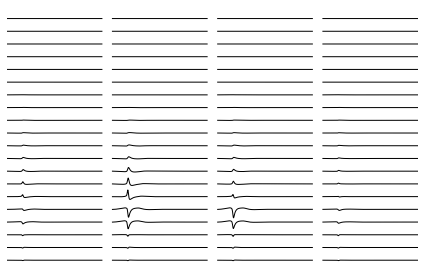

In [13]:
ax = mu.plot_mea_recording(eap, probe)

## 2) Generate feature and protocols with BluePyEfe

In [8]:
sys.path.append('../efeatures_extraction')

In [9]:
efeatures_output_directory = Path(f"../data/{model_name}_ecode_probe_{probe_type}/efeatures")

In [10]:
from bluepyefe.extract import read_recordings, extract_efeatures_at_targets, compute_rheobase,\
    mean_efeatures, create_feature_protocol_files
from bluepyefe.plotting import plot_all_recordings_efeatures

from extraction_tools import build_model_metadata, model_csv_reader, get_targets, ecodes_model_timings

In [11]:
files_metadata = build_model_metadata(cell_id=model_name, ephys_dir=output_folder)
pprint(files_metadata[model_name])

{'APWaveform': [{'filepath': '../data/hay_ecode_probe_planar/APWaveform/APWaveform-1.csv',
                 'i_unit': 'nA',
                 't_unit': 'ms',
                 'toff': 300,
                 'ton': 250,
                 'v_unit': 'mV'},
                {'filepath': '../data/hay_ecode_probe_planar/APWaveform/APWaveform-0.csv',
                 'i_unit': 'nA',
                 't_unit': 'ms',
                 'toff': 300,
                 'ton': 250,
                 'v_unit': 'mV'},
                {'filepath': '../data/hay_ecode_probe_planar/APWaveform/APWaveform-4.csv',
                 'i_unit': 'nA',
                 't_unit': 'ms',
                 'toff': 300,
                 'ton': 250,
                 'v_unit': 'mV'},
                {'filepath': '../data/hay_ecode_probe_planar/APWaveform/APWaveform-2.csv',
                 'i_unit': 'nA',
                 't_unit': 'ms',
                 'toff': 300,
                 'ton': 250,
                 'v_unit': 'mV'},


In [12]:
cells = read_recordings(
    files_metadata=files_metadata,
    recording_reader=model_csv_reader
)

In [13]:
# define target features for different protocols
targets = get_targets(ecodes_model_timings)
pprint(targets)

{'APWaveform': {'amplitudes': [180, 260],
                'efeatures': ['AP_amplitude',
                              'AP1_amp',
                              'AP2_amp',
                              'AP_duration_half_width',
                              'AP_begin_width',
                              'AP_begin_voltage',
                              'AHP_depth',
                              'AHP_time_from_peak'],
                'location': 'soma',
                'tolerances': [20]},
 'HyperDepol': {'amplitudes': [-120],
                'efeatures': {'AP_amplitude': {'stim_end': 970,
                                               'stim_start': 700},
                              'ISI_values': {'stim_end': 970,
                                             'stim_start': 700},
                              'Spikecount': {'stim_end': 970,
                                             'stim_start': 700},
                              'burst_number': {'stim_end': 970,
                    

In [14]:
t_start = time.time()
extract_efeatures_at_targets(
    cells, 
    targets,
)
t_stop = time.time()
print(f"Elapsed time {t_stop - t_start}")

/gpfs/bbp.cscs.ch/home/mandge/code/BPE2/BluePyEfe/bluepyefe/recording.py:218: RuntimeWarning: Mean of empty slice
  self.efeatures[feature] = numpy.nanmean(value)


Elapsed time 22.848796129226685


In [15]:
compute_rheobase(
    cells, 
    protocols_rheobase=['IDthres']
)

In [16]:
protocols = mean_efeatures(cells, targets, use_global_rheobase=True)

Could not compute average ecode for protocol APWaveform target 180 because it didn't match any recordings
Could not compute average ecode for protocol HyperDepol target -120 because it didn't match any recordings


In [17]:
efeatures, protocol_definitions, current = create_feature_protocol_files(
    cells,
    protocols,
    output_directory=efeatures_output_directory,
    threshold_nvalue_save=1,
    write_files=True,
)

Standard deviation for efeatures mean_frequency for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures burst_number for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures adaptation_index2 for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures ISI_CV for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures ISI_log_slope for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures inv_time_to_first_spike for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures inv_first_ISI for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures inv_second_ISI for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures inv_third_ISI for stimulus firepattern_120 is 0. and will be set to 1e-3
Standard deviation for efeatures inv_f

## 3) Convert to BPO format and append extra features

In [18]:
from extraction_tools import convert_to_bpo_format, append_extrafeatures_to_json, compute_extra_features

In [19]:
protocols_of_interest = ["firepattern_200", "IV_-100", "APWaveform_260"]

in_protocol_path = efeatures_output_directory / "protocols.json"
in_efeatures_path = efeatures_output_directory / "features.json"

out_protocol_path = efeatures_output_directory / "protocols_BPO_test.json"
out_efeatures_path = efeatures_output_directory / "features_BPO_test.json"

In [20]:
protocols_dict, efeatures_dict = convert_to_bpo_format(in_protocol_path, in_efeatures_path, 
                                                       out_protocol_path, out_efeatures_path, 
                                                       protocols_of_interest=protocols_of_interest, 
                                                       std_from_mean=0.2)

Found ['soma'] locations
Saving protocols and features for the following protocols:
['firepattern_200', 'IV_-100', 'APWaveform_260']


In [21]:
efeatures_dict

{'soma': {'firepattern_200': {'soma': {'mean_frequency': [13.510565684538028,
     2.702113136907606],
    'burst_number': [1.0, 0.2],
    'adaptation_index2': [0.02033621522753898, 0.004067243045507796],
    'ISI_CV': [0.22527001079791825, 0.045054002159583655],
    'ISI_log_slope': [0.3420125654718753, 0.06840251309437506],
    'inv_time_to_first_spike': [96.1538461619125, 19.2307692323825],
    'inv_first_ISI': [107.23860589822085, 21.447721179644173],
    'inv_second_ISI': [90.09009009017203, 18.018018018034407],
    'inv_third_ISI': [79.20792079215124, 15.84158415843025],
    'inv_fourth_ISI': [53.61930294911043, 10.723860589822086],
    'inv_fifth_ISI': [16.103059581335096, 3.2206119162670195],
    'AP_amplitude': [72.74199694581527, 14.548399389163055],
    'AHP_depth': [10.38030004406263, 2.076060008812526],
    'AHP_time_from_peak': [3.1536458333410473, 0.6307291666682096]}},
  'IV_-100': {'soma': {'Spikecount': [0.0, 0.0],
    'voltage_base': [-76.67747466895133, -15.33549493

In [22]:
# append MEA.LFP features
eap = np.load(output_folder / "extracellular" / "template.npy")
fs = np.load(output_folder / "extracellular" / "fs.npy")

In [23]:
extra_features = compute_extra_features(eap, fs, upsample=10)

In [24]:
pprint(extra_features)

{'halfwidth': array([ 0.000325,  0.00032 , -0.00596 , -0.00629 , -0.005515, -0.000915,
       -0.001395, -0.00277 ,  0.00545 ,  0.0054  ,  0.00536 ,  0.0053  ,
        0.00511 ,  0.001405,  0.00138 ,  0.001355,  0.001335,  0.001325,
        0.00134 ,  0.001365,  0.00032 ,  0.000305, -0.005905, -0.006405,
       -0.006305, -0.00086 , -0.00138 , -0.002075,  0.005405,  0.00539 ,
        0.00538 ,  0.005365,  0.00518 ,  0.001345,  0.001315,  0.00129 ,
        0.001265,  0.00127 ,  0.001305,  0.00135 ,  0.000325,  0.00031 ,
       -0.005815, -0.00639 , -0.006355, -0.000785, -0.00166 ,  0.005425,
        0.005385,  0.005395,  0.00537 ,  0.005325,  0.00515 ,  0.001395,
        0.001375,  0.00136 ,  0.001355,  0.001355,  0.001375,  0.00139 ,
        0.00033 ,  0.000325, -0.00421 , -0.006245, -0.00631 , -0.00064 ,
        0.0059  ,  0.00542 ,  0.005295,  0.00535 ,  0.00534 ,  0.005285,
        0.00515 ,  0.001445,  0.001425,  0.001415,  0.00141 ,  0.00141 ,
        0.001415,  0.001425]),
 'neg_

In [25]:
efeatures_dict = append_extrafeatures_to_json(extra_features, protocol_name="firepattern_200",
                                              efeatures_path=out_efeatures_path)

<AxesSubplot:>

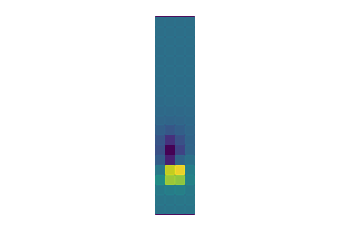

In [26]:
# plot one extra features
plotting.plot_feature_map(extra_features["neg_image"], probe)